# Examples of using the nibabel module to read MR thermometry data

In [3]:
import sys

from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import importlib
import sonalleve
import transducers
#from matplotlib.mlab import griddata

import matplotlib.transforms as mpl_trans

import scipy.interpolate as snt
import scipy.ndimage.filters as sflt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import MRDataAnalysis
from MRDataAnalysis import rescale as rescaleIm

import nibabel
import visvis as vv
#os.chdir('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\path_optimization\\')

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=1300)

plt.rc('font', family='sans-serif', size=20)



In [502]:
importlib.reload(geom)

<module 'geom' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\geom.py'>

In [459]:
np.percentile(t2wData,50)

0.0018326206475259622

In [4]:
def rescaleIm(inArray,newmin=0.0,newmax=1.0,vmin=None,vmax=None,trunc=False):
    """
    Rescale input array values to the range [newmin, newmax]
    Keywords & defaults: newmin=0.0, newmin=1.0
        vmin=  The value in input array that will be mapped to newmin. Default=min(inArray)
        vmax=  The value in input array that will be mapped to newmax. Default=max(inArray)
        trunc=  If true, truncate the output range. Values less than newmin will be set to newmin. Likewise for newmax.
    """
    oldmin = np.min(inArray)
    oldmax = np.max(inArray)
    
    if vmin is None:
        vmin = oldmin
    if vmax is None:
        vmax = oldmax
        
    newim = (inArray - vmin)*(newmax - newmin) / (vmax - vmin) + newmin
    
    if trunc:
        newim[newim < newmin] = newmin
        newim[newim > newmax] = newmax
        
    return newim
    

In [460]:
t2wfile=parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\\Hifu_20150924\\egg1\\Caskey_20150924_WIP_T2w_Planning_SENSE_21_1.PAR"
#t2wfile=parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuEggAg_20160211\\Caskey_20160211_WIP_T2w_TE40_CLEAR_21_1.PAR"
#t2wfile=parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuMed_20160216\\Caskey_20160217_WIP_T2w_Planning_CLEAR_4_1.PAR"
t2wfile=parfil="/Users/Vandiver/Data/sonalleve/HifuVol_20160223B/scan16_T2w_20160223B.PAR"
t2wObj=nibabel.load(t2wfile,scaling='fp')



t2wData=t2wObj.get_data()
t2SmallestFilledVal = np.min(t2wData[t2wData>0])

t2wData= rescaleIm( t2wData, newmin=0.0, vmin=t2SmallestFilledVal, trunc=True )

t2wvox0=np.arange(0,t2wData.shape[0])
t2wvox1=np.arange(0,t2wData.shape[1])
t2wvox2=np.arange(0,t2wData.shape[2])


#t2wvox0=np.arange(60,130)
#t2wvox1=np.arange(75,105)
#t2wData = t2wData[np.ix_(t2wvox0,t2wvox1,t2wvox2)]

t2waffine = t2wObj.get_affine()

vtX, vtY = np.meshgrid(t2wvox0, t2wvox1,indexing='ij')

t2wDX,t2wDY,t2wDZ,junk=np.abs( t2wObj.get_affine().dot([1,1,1,0]) )

print(t2wData.shape)

(336, 336, 50)


In [38]:
tw2DZ

0.53000000000000003

In [119]:
new_nii_filename = t2wfile[0:-4] + 'bestaff.nii'

#imgObj.get_affine()

scaleddata = t2wData * 30.0 / np.max(t2wData)
new_img = nibabel.Nifti1Image(scaleddata,t2wObj.header.get_best_affine() )
new_img.set_data_dtype(np.float32)
nibabel.save(new_img,new_nii_filename)

In [275]:
t2wObj.get_affine()

array([[ -0.676,   0.   ,   0.   ,  91.898],
       [  0.   ,   0.   ,  -1.3  ,  13.752],
       [  0.   ,  -0.676,   0.   ,  90.443],
       [  0.   ,   0.   ,   0.   ,   1.   ]])

In [565]:
parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\\Hifu_20150924\\egg1\\Caskey_20150924_WIP_TempMapEgg1_CLEAR_20_1.PAR"
parfil="/Users/Vandiver/Data/sonalleve/HifuVol_20160223B/scan14_TempTrans_20160223B.PAR"
parfil="/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/scan15_TempTrans_20160223.PAR"
#parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuEggAg_20160211\\Caskey_20160211_WIP_Tmap_SingleFocStatic_40W_CLEAR_18_1.PAR"
#parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuEggAg_20160211\\Caskey_20160211_WIP_Temp_MultiTrajA_60W_CLEAR_15_1.PAR"
#parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuEggAg_20160211\\Caskey_20160211_WIP_TemperatureMapping_CLEAR_10_1.PAR"

#parfil="C:\\Users\\Vandiver\\Data\\sonalleve\\HifuMed_20160216\\Caskey_20160217_WIP_TemperatureMapping_CLEAR_3_1.PAR"

imgObj=nibabel.load(parfil,scaling='fp')
imgData=imgObj.get_data()

header=imgObj.get_header()
numdyns = header.general_info['max_dynamics']

Taffine=imgObj.header.get_affine()
invTempAffine=np.linalg.inv(Taffine)

#Only Mag & Phase (M,P) images saved
imginfo={}
imginfo["ty"] = np.array(list(map( lambda rec: rec[4], imgObj.header.image_defs )))
imginfo["sl"] = np.array(list(map( lambda rec: rec[0], imgObj.header.image_defs )))
imginfo["dyn"] = np.array(list(map( lambda rec: rec[2], imgObj.header.image_defs )))

if imginfo["ty"][0] != imginfo["ty"][1]:
    Mag_inds = np.arange(0,2*numdyns,2)
    Phs_inds = np.arange(1,2*numdyns,2)
else:
    Mag_inds = np.arange(0,numdyns)
    Phs_inds = np.arange(numdyns,2*numdyns)

Mag_inds = np.arange(0,2*numdyns,2)
Phs_inds = np.arange(1,2*numdyns,2)    

##add check for interleaving
complexImgSeries = imgData[:,:,:,Mag_inds]* np.exp(1j * imgData[:,:,:,Phs_inds])

TE_ms = 16
B0_T = 3.0
ang2temp = 1.0 / (42.576*0.01*B0_T*TE_ms*1e-3*pi)

tempSeries = np.zeros(complexImgSeries.shape)
for dn in range(0,numdyns):
    tempSeries[:,:,:,dn] = np.angle( complexImgSeries[:,:,:,0] * np.conj(complexImgSeries[:,:,:,dn]) )
    
#orig=tempSeries[72,70,7,:].copy()

#phase correct
for dn in range(1,numdyns):
    mask= (tempSeries[:,:,:,dn] - tempSeries[:,:,:,dn-1]) < (-1.*pi)
    tempSeries[mask,dn] += 2*pi
    
    #mask= (tempSeries[:,:,:,dn] ) < (-0.2*pi)
    #tempSeries[mask,dn] += 2*pi


tempSeries*=ang2temp
    
nnM,nnP,nnS,nd=tempSeries.shape
tempSeries.shape

(144, 144, 10, 15)

In [474]:
imgObj.header.get_sorted_slice_indices().shape

(1800,)

In [466]:
imginfo["ty"][0] != imginfo["ty"][1]

False

In [467]:
imginfo["ty"]

array([0, 0, 0, ..., 3, 3, 3])

In [4]:
imgData.shape

(144, 144, 15, 40)

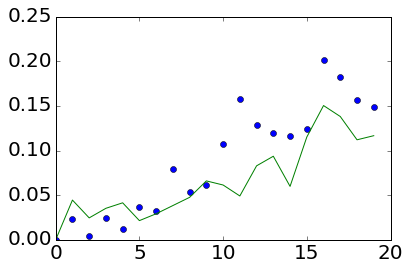

In [543]:
#plt.plot(orig)
plt.plot(tempSeries[73,72,6,:] / ang2temp,'o')
plt.plot(tempSeries[72,70,5,:] / ang2temp)

In [763]:
(tempSeries[73,72,6,9] - tempSeries[73,72,6,8])/  ang2temp

-5.5835197963930758

In [1108]:
t2wData.shape

(192, 192, 20)

In [110]:
new_nii_filename = parfil[0:-4] + 'bestaff_.nii'

#imgObj.get_affine()
new_img = nibabel.Nifti1Image(tempSeries[:,:,:,-1], imgObj.header.get_base_affine() )
new_img.set_data_dtype(np.float32)
nibabel.save(new_img,new_nii_filename)

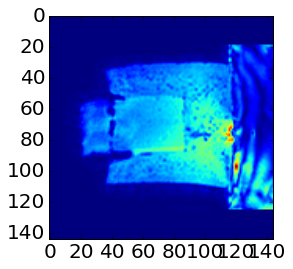

In [542]:
plt.imshow( rescaleIm(np.abs(complexImgSeries[:,:,10,1])) )

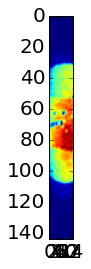

In [487]:
plt.imshow( rescaleIm(np.abs(complexImgSeries[:,85,:,0])) )

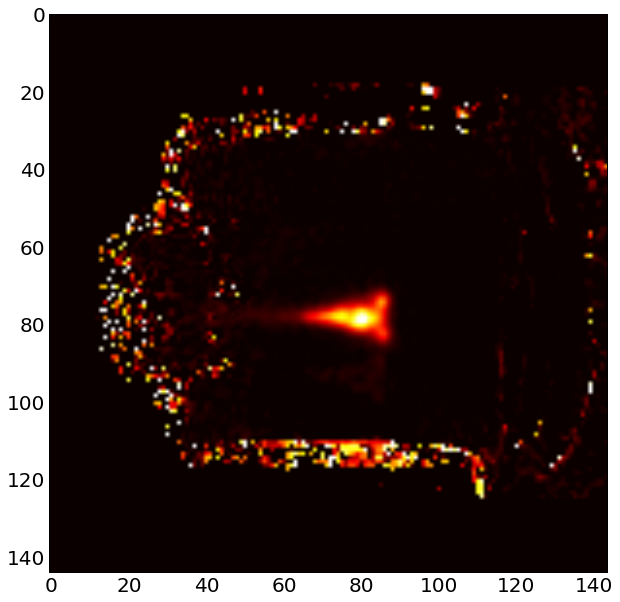

In [564]:
plt.figure(figsize=(10,10))
plt.imshow( tempSeries[:,:,5,14], cmap=image.cm.hot, vmin=0, vmax=60)

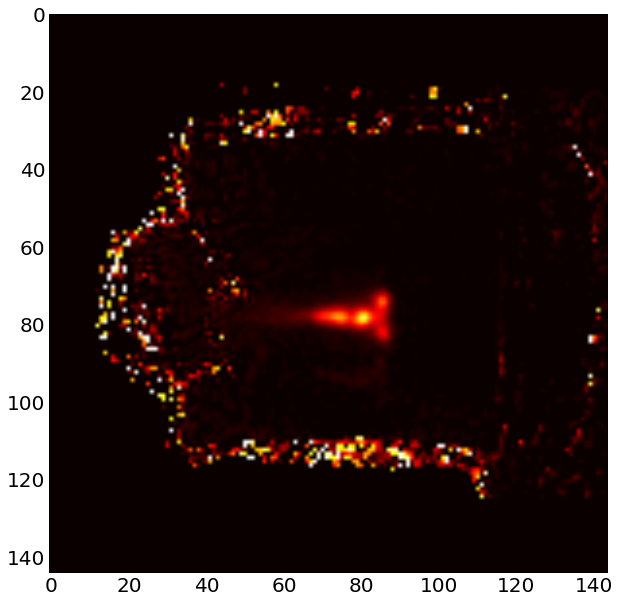

In [566]:
plt.figure(figsize=(10,10))
plt.imshow( tempSeries[:,:,5,14], cmap=image.cm.hot, vmin=0, vmax=60)

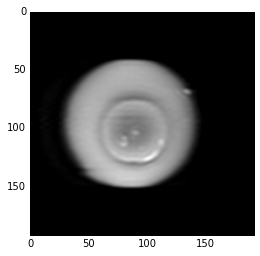

In [1258]:
plt.imshow(rescaleIm(t2wData[:,:,14], vmin=np.percentile(t2wData,60),vmax=np.percentile(t2wData,100), trunc=True), cmap=image.cm.gray )

In [547]:
dyn=18


vox0 = np.linspace(0., nnM, nnM)
vox1 = np.linspace(0., nnP, nnP)
vmX, vmY = np.meshgrid(vox0, vox1,indexing='ij')

Taffine=imgObj.header.get_affine()

a=vv.gca()
a.light0.ambient=1.0
a.light0.diffuse=0.0

for zi in [8]:
    vox2 = [zi]

    rX,rY,rZ=geom.rotate_mesh_volume(Taffine[:3, :3], vmX, vmY, vox2, translate=Taffine[:3, 3])
    
    Tslice = tempSeries[:,:,zi,dyn]
    
    greymask=Tslice<3.0
    greyImg = rescaleIm(np.abs(complexImgSeries[greymask,zi,dyn]))
    
    scaledIm = rescaleIm(Tslice, vmin=0,vmax=30,trunc=True)
    #scaledIm = rescaleIm(imgData[:,:,zi,dyn])
    
    rgbaIm = image.cm.hot(scaledIm)
    rgbaIm[greymask,0:3] = np.transpose(np.array([greyImg, greyImg, greyImg]))
    
    m = vv.surf(rX,rY,rZ, rgbaIm )
    #m.colormap=vv.CM_HOT
    m.ambient=1.0
    m.diffuse=0.0
    #m.faceShading='flat'


Pi=86
vmM, vmP, vmS = np.meshgrid(vox0, [Pi], np.linspace(0., nnS, nnS),indexing='ij')
rX,rY,rZ=geom.rotate_mesh_volume(Taffine[:3, :3], vmM, vmP, vmS, translate=Taffine[:3, 3])
m = vv.surf(rX,rY,rZ, rescaleIm(np.abs(complexImgSeries[:,Pi,:,0]))  )
m.colormap=vv.CM_GRAY

Mi=76
vmM, vmP, vmS = np.meshgrid(Mi, vox1, np.linspace(0., nnS, nnS),indexing='ij')
rX,rY,rZ=geom.rotate_mesh_volume(Taffine[:3, :3], vmM, vmP, vmS, translate=Taffine[:3, 3])

TsliceM = tempSeries[Mi,:,:,dyn]
greymask=TsliceM<4.0
greyImg = rescaleIm(np.abs(complexImgSeries[Mi,greymask,0]))

rgbaImMi =  image.cm.hot(rescaleIm(TsliceM, vmin=0,vmax=30,trunc=True))
rgbaImMi[greymask,0:3] = np.transpose(np.array([greyImg, greyImg, greyImg]))
m = vv.surf(rX,rY,rZ, rgbaImMi )
#m.colormap=vv.CM_GRAY

    

Mslice=210
vvx,vvy,vvz=np.meshgrid([Mslice], t2wvox1,t2wvox2, indexing='ij')
T2planePS = t2wData[Mslice,:,:]
tyzX,tyzY,tyzZ=np.squeeze( geom.rotate_mesh_volume(t2waffine[:3, :3], vvx,vvy,vvz, translate=t2waffine[:3, 3]) )



t2slice=66   
#T2plane = t2wData[:,:,t2slice]
#tX,tY,tZ=geom.rotate_mesh_volume(t2waffine[:3, :3], vtX, vtY, t2slice, translate=t2waffine[:3, 3])


#tX,tY,tZ=geom.rotate_mesh_volume(t2waffine[:3, :3], vtX, vtY, t2slice, translate=t2waffine[:3, 3])
#tsrf = vv.surf(tyzX,tyzY,tyzZ, rescaleIm(T2planePS, vmin=0.01,vmax=0.2, trunc=True) )

#tsrf = vv.surf(tX,tY,tZ, rescaleIm(T2plane, vmin=0.01,vmax=0.2, trunc=True) )

#vmin=np.percentile(t2wData,0), vmax=np.percentile(t2wData,100), 

#tsrf.colormap=vv.CM_GRAY
#tsrf.ambient=0.5
#tsrf.edgeShading=None
#tsrf.faceShading='flat'


app=vv.use()
app.Run()

In [149]:
#t2inds0 = np.arange(60,130)
#t2inds1 = np.arange(75,105)
#t2inds2 = np.arange(0,t2wData.shape[2])

t2inds0 = np.arange(150,200)
t2inds1 = np.arange(140,170)
t2inds2 = np.arange(50,80)


t2VolSegment = t2wData[np.ix_(t2inds0, t2inds1, t2inds2)]

vt0, vt1,vt2 = np.meshgrid( t2inds0.astype(np.float), t2inds1.astype(np.float), t2inds2.astype(np.float),indexing='ij')
print(len(t2inds0)*len(t2inds1)*len(t2inds2))

45000


In [150]:
t2rasX,t2rasY,t2rasZ=geom.rotate_mesh_volume(t2waffine[:3, :3], vt0, vt1, vt2, translate=t2waffine[:3, 3])
locationsIn = np.transpose( np.array([t2rasX.flatten(), t2rasY.flatten(), t2rasZ.flatten()]) )

In [687]:
#locationsIn = np.zeros([np.product(t2rasX.shape),3] )
#locationsIn[:,0] = t2rasX.flatten()
#locationsIn[:,1] = t2rasY.flatten()
#locationsIn[:,2] = t2rasZ.flatten()

In [87]:
locationsIn.shape

(12000, 3)

In [157]:
#temperature map segment
vox0 = np.arange(50, 90)
vox1 = np.arange(50, 95)
#vox2 = [8]

#vox0 = np.arange(0, nnM)
#vox1 = np.arange(0, nnP)
vox2 = np.arange(0, nnS)

vm0, vm1, vm2 = np.meshgrid( vox0.astype(np.float), vox1.astype(np.float), vox2.astype(np.float),indexing='ij')

Taffine=imgObj.header.get_affine()
vrX,vrY,vrZ=geom.rotate_mesh_volume(Taffine[:3, :3], vm0, vm1, vm2, translate=Taffine[:3, 3])

dyn=18
Tsegment = np.squeeze( tempSeries[np.ix_(vox0,vox1,vox2,[dyn])] )


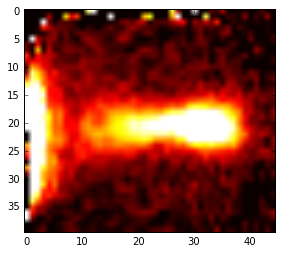

In [158]:
plt.imshow( Tsegment[:,:,7], vmin=0,vmax=30,cmap=image.cm.hot)

In [1368]:
dyn=9
Tsegment = np.squeeze( tempSeries[np.ix_(vox0,vox1,vox2,[dyn])] )

In [159]:
temppoints = np.transpose( np.array([vrX.flatten(), vrY.flatten(), vrZ.flatten()]) )

In [160]:
interpT2onTemp = snt.griddata(locationsIn, t2VolSegment.flatten(), (vrX,vrY,vrZ), fill_value=0.0, method='linear' )

In [162]:
interpTempOnT2 = snt.griddata(temppoints, Tsegment.flatten(), (t2rasX,t2rasY,t2rasZ), fill_value=0, method='linear' )

In [216]:
np.transpose( np.array([vrX.flatten(), vrY.flatten(), vrZ.flatten()]) ).shape

(27000, 3)

In [550]:
np.max(interpT)

15953278.984858744

In [94]:
np.min(t2VolSegment)

memmap(0.0)

In [182]:
interpTempOnT2.shape

(50, 30, 30)

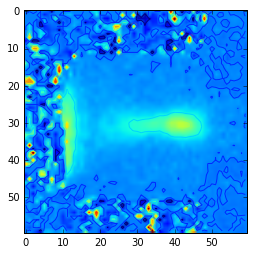

In [97]:
plt.imshow( np.squeeze( tempSeries[np.ix_(vox0,vox1,[7],[18])] )  )
plt.contour(np.squeeze( tempSeries[np.ix_(vox0,vox1,[7],[18])] ))

In [98]:
np.min(interpT2onTemp[:,:,zi])

0.0

In [704]:
Tsegment.shape

(40, 40, 8)

In [710]:
np.arange(0,60.001,10)

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.])

In [81]:
axTable

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017BCE8D0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000F699E80>], dtype=object)

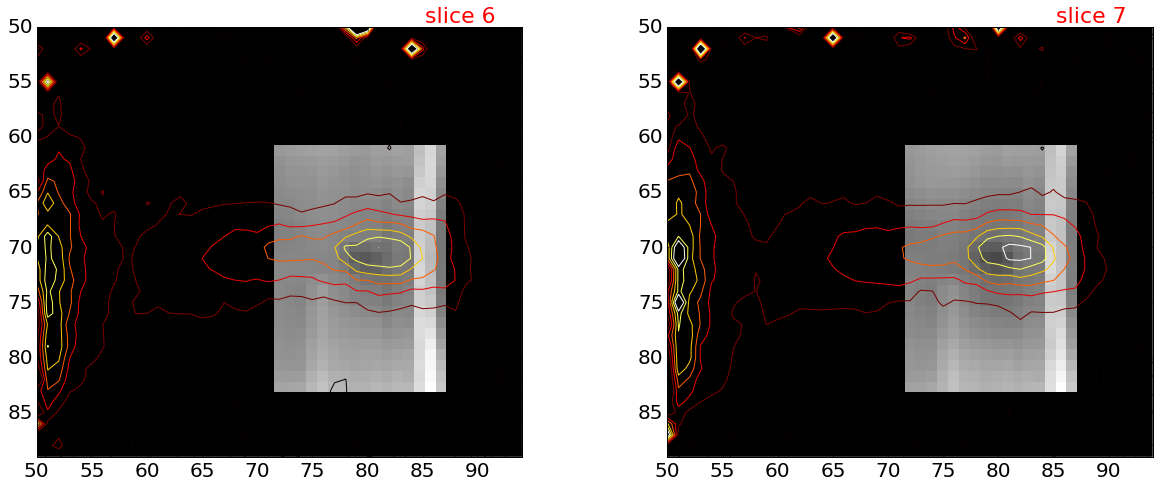

In [173]:
zi=7
zlist=[6,7]
#fig=plt.figure(figsize=(8,8))
fig,axTable=plt.subplots(nrows=1,ncols=len(zlist),sharey=False,sharex=False,gridspec_kw=dict(wspace=0.3,hspace=0.15), figsize=(20,15))

axTable=axTable.flatten()
for i in range(len(zlist)):
    zi=zlist[i]
    ax=axTable[i]
    ax.imshow( interpT2onTemp[:,:,zi],cmap=image.cm.gray, vmin=0.0, interpolation='none', extent=[ vox1[0], vox1[-1], vox0[-1],vox0[0] ] )
    ax.contour(vox1, vox0, Tsegment[:,:,zi], np.arange(0,60.001,10), cmap=image.cm.hot)
    ax.text(0.8,1.01,"slice %d"%zi, fontsize=22, fontdict=dict(color='red'),transform=ax.transAxes)

In [405]:
numdyns

20

In [390]:
t2vox0 = np.arange(60,210)
#t2vox1 = np.arange(140,170)
t2vox1 = np.arange(150,156)
t2vox2 = np.arange(50,100)

t2MPSmesh = np.meshgrid(t2vox0.astype(float),t2vox1,t2vox2, indexing='ij')

t2RASmesh = geom.rotate_mesh_volume(t2waffine[0:3,0:3], *t2MPSmesh, translate=t2waffine[0:3,3] )

t2MPS2TempMesh = geom.rotate_mesh_volume(invTempAffine[0:3,0:3], *t2RASmesh, translate=invTempAffine[0:3,3] )



#np.linalg.inv(t2waffine).dot( imgObj.get_affine().dot([72,80,7,1]) ) - [t2inds0[0], t2inds1[0], t2inds2[0], 1]

In [392]:
#vox0 = np.arange(0, nnM)
#vox1 = np.arange(0, nnP)
#vox2 = np.arange(0, nnS)

vox0,vox1,vox2 = tuple(map ( lambda msh: np.arange(floor(np.min( msh )), ceil(np.max(msh)) + 1), t2MPS2TempMesh))

vm0, vm1, vm2 = np.meshgrid( vox0.astype(np.float), vox1.astype(np.float), vox2.astype(np.float),indexing='ij')

temppoints = np.array([vm0.flatten(), vm1.flatten(), vm2.flatten()]).transpose() 


In [393]:
temppoints.shape

(7840, 3)

In [394]:

interpTempOnT2 = snt.griddata(temppoints, tempSeries[np.ix_(vox0,vox1,vox2,[18])].flatten(), t2MPS2TempMesh, fill_value=0, method='linear' )

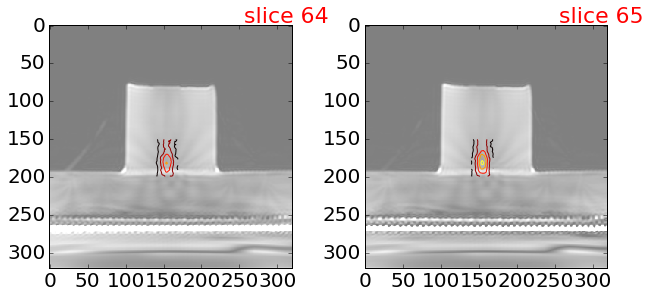

In [341]:
slist=t2vox2
fig,axTable=plt.subplots(nrows=1,ncols=len(slist),sharey=False,sharex=False,gridspec_kw=dict(wspace=0.3,hspace=0.15), figsize=(10,10))

if type(axTable) == np.ndarray:
    axTable=axTable.flatten()
else:
    axTable=[axTable]
    
for i in range(len(slist)):
    zi=slist[i]
    ax=axTable[i]
    ax.hold(True)
    img=ax.imshow( t2wData[:,:,zi],cmap=image.cm.gray, vmin=0.0,vmax=0.2,alpha=0.5, interpolation='none' )
    #ax.contour(t2inds1, t2inds0, interpTempOnT2[:,:,zi-t2inds2[0]], np.arange(10,60.001,10), cmap=image.cm.hot)
    ax.contour(t2vox1, t2vox0, interpTempOnT2[:,:,zi-t2vox2[0]], np.arange(10,60.001,10), cmap=image.cm.hot)
    
    #ax.imshow( interpTempOnT2[:,:,zi-t2vox2[0]], cmap=image.cm.hot, alpha=0.5,vmin=0.0,vmax=30, interpolation='none', mask= )
    
    #ax.imshow( interpTempOnT2[:,:,zi-t2vox2[0]],cmap=image.cm.hot, vmin=0.0,vmax=30, interpolation='none', extent=[ t2vox1[0], t2vox1[-1], t2vox0[-1],t2vox0[0]] )
    ax.text(0.8,1.01,"slice %d"%zi, fontsize=22, fontdict=dict(color='red'),transform=ax.transAxes)

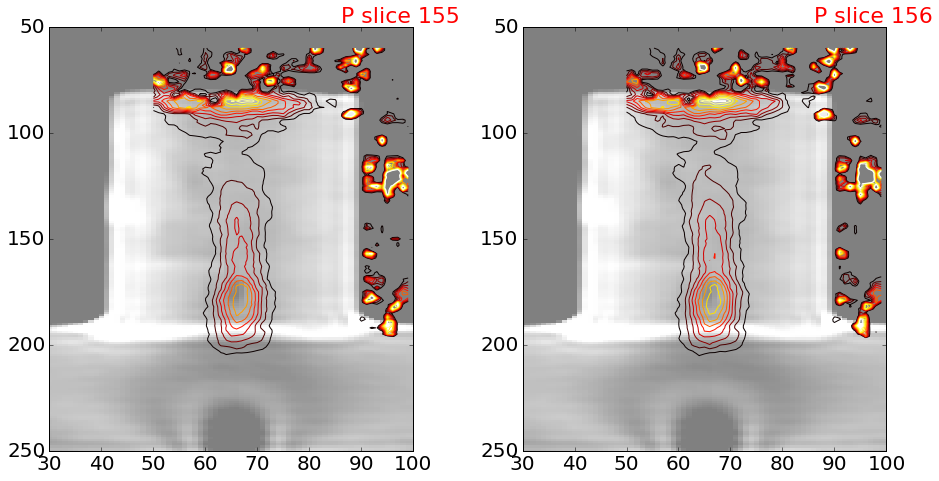

In [407]:
plist=t2vox1
plist=[155,156]
fig,axTable=plt.subplots(nrows=1,ncols=len(plist),sharey=False,sharex=False,gridspec_kw=dict(wspace=0.3,hspace=0.15), figsize=(15,10))

if type(axTable) == np.ndarray:
    axTable=axTable.flatten()
else:
    axTable=[axTable]
    
    
    
for i in range(len(plist)):
    yi=plist[i]
    ax=axTable[i]
    ax.hold(True)
    img=ax.imshow( t2wData[:,yi,:],cmap=image.cm.gray, vmin=0.05,vmax=0.15,alpha=0.5, interpolation='none' )
    ax.contour(t2vox2, t2vox0, interpTempOnT2[:,i,:], np.arange(10,60.001,5), cmap=image.cm.hot)
    ax.set_aspect(t2wDZ/t2wDX)
    ax.set_xlim(left=30,right=100)
    ax.set_ylim(bottom=250,top=50)
    ax.text(0.8,1.01,"P slice %d"%yi, fontsize=22, fontdict=dict(color='red'),transform=ax.transAxes)

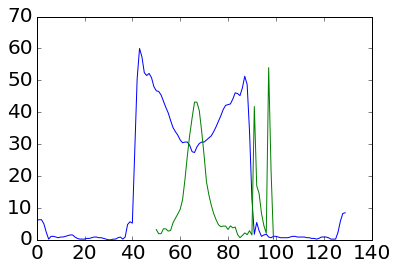

In [403]:
i=0
yi=plist[i]
plt.plot( rescaleIm( t2wData[180,yi,:], newmax=60) )
plt.plot( t2vox2, interpTempOnT2[180-t2vox0[0],i,:])

In [1198]:
t2scmin=np.min(t2VolSegment[:,:,9])
t2scmax=np.max(t2VolSegment)

tsrf = vv.surf(t2rasX[:,:,9],t2rasY[:,:,9],t2rasZ[:,:,9], rescaleIm(t2VolSegment[:,:,9],vmin=t2scmin,vmax=t2scmax) )
tsrf.colormap=vv.CM_GRAY


tsrf = vv.surf(t2rasX[:,:,1],t2rasY[:,:,1],t2rasZ[:,:,1], rescaleIm(t2VolSegment[:,:,1],vmin=t2scmin,vmax=t2scmax) )
tsrf.colormap=vv.CM_GRAY

tsrf = vv.surf(vrX[:,:,6],vrY[:,:,6],vrZ[:,:,6], rescaleIm(interpT2onTemp[:,:,6],vmin=t2scmin,vmax=t2scmax) )
tsrf.colormap=vv.CM_GRAY
#tsrf.edgeColor

app=vv.use()
app.Run()

In [554]:
scaledIm = rescaleIm(tempSeries[:,:,zi,dyn],newmin=0,newmax=1, llt=0.0,ult=30,trunc=True)
rgbaIm = image.cm.hot(scaledIm)
m = vv.surf(rX,rY,rZ, rgbaIm)


In [385]:
image.cm.hot(scaledIm).shape

(144, 144, 4)

In [58]:
newImObj=nibabel.load(new_nii_filename)

In [61]:
newImData=newImObj.get_data()

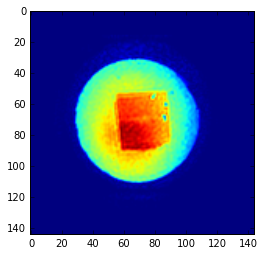

In [62]:
plt.imshow(imgData[:,:,4,24])

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
X = np.linspace(0., nnM, nnM)
Y = np.linspace(0., nnP, nnP)
Z = [0.0]

zi=6

Rmat=geom.getRotZYZarray(45,45,0)

mX, mY = np.meshgrid(X, Y)

rX,rY,rZ=geom.rotate_mesh_volume(Rotmat,mX,mY,Z)


scaledIm = rescaleIm(tempSeries[:,:,zi,-1], vmin=0.0,vmax=30)

coloring = image.cm.hot( scaledIm )
surf = ax.plot_surface(rX, rY, rZ, rstride=1, cstride=1, facecolors=coloring, 
                       linewidth=0, antialiased=False)

ax.elev=80
ax.azi=0
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

In [2]:
import sqlite3 as sql

In [3]:
db = "/Users/Vandiver/Data/sonalleve/sonalleve_copy.db"

In [4]:
con = sql.connect(db)

In [8]:
con.row_factory = sql.Row

In [5]:
val='Caskey_20150731_WIP_TemperatureMapping_CLEAR_14_1.PAR'

In [21]:
cur=con.execute("select * from data where file = ?", [val] )

In [85]:
cur=con.execute("select max(fid) from data")

In [35]:
rd['file']='test'

In [86]:
r=cur.fetchone()

In [90]:
con.execute("select max(fid) from data").

58

In [3]:
import shutil
import re
import os
import glob

In [419]:
glob.glob("/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).*")

['/Users/Vandiver/Data/sonalleve/HifuNanos_20160223\\Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).PAR',
 '/Users/Vandiver/Data/sonalleve/HifuNanos_20160223\\Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).REC',
 '/Users/Vandiver/Data/sonalleve/HifuNanos_20160223\\Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).V41',
 '/Users/Vandiver/Data/sonalleve/HifuNanos_20160223\\Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).XML']

In [421]:
filen="/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).XML"

In [427]:
filen="/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/Caskey_20160223_10_01_20.34.08_(WIP_TempTrans_CLEAR).XML.XML"

In [422]:
os.path.basename(filen)

'Caskey_20160223_02_01_19.49.23_(WIP_Transducer_Survey_CLEAR).XML'

In [448]:
os.path.extsep

'.'

In [453]:
extstr=re.search("\.(\w*)$",filen).group(1)

In [437]:
re.search("Temp[a-zA-Z0-9]*",filen)

<_sre.SRE_Match object; span=(86, 95), match='TempTrans'>

In [425]:
re.search("Survey*",filen)

<_sre.SRE_Match object; span=(97, 103), match='Survey'>

In [454]:
dateidx=1; 
scanidx=2;
typeidx=6;
(scanstr,typestr,datestr)=[re.split("_",os.path.basename(filen))[i] for i in [scanidx,typeidx,dateidx] ]

"scan%s_%s_%s.%s"%(scanstr,typestr,datestr,extstr)


'scan10_TempTrans_20160223.XML'

In [ ]:
shutil.move()

In [455]:
os.path.abspath(filen)

'C:\\Users\\Vandiver\\Data\\sonalleve\\HifuNanos_20160223\\Caskey_20160223_10_01_20.34.08_(WIP_TempTrans_CLEAR).XML.XML'

In [456]:
os.path.dirname(filen) + os.path.basename(filen)

'/Users/Vandiver/Data/sonalleve/HifuNanos_20160223'

In [457]:
os.pathsep

';'

In [458]:
os.path.join(os.path.dirname(filen), os.path.basename(filen))

'/Users/Vandiver/Data/sonalleve/HifuNanos_20160223\\Caskey_20160223_10_01_20.34.08_(WIP_TempTrans_CLEAR).XML.XML'

In [989]:
importlib.reload(MRDataAnalysis)

<module 'MRDataAnalysis' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\MRDataAnalysis.py'>

In [4]:
import MRDataAnalysis

In [5]:
file1="/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/scan10_TempTrans_20160223.PAR"
file2="/Users/Vandiver/Data/sonalleve/HifuNanos_20160223/scan13_TempTrans_20160223.PAR"

file1="/Users/Vandiver/Data/sonalleve/Hifu_20160317/scan22_TempCo_20160317.PAR"
file2="/Users/Vandiver/Data/sonalleve/Hifu_20160317/scan23_TempCo_20160317.PAR"

(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1,MP_interleaved=True, phase_unwrap=1., pi_val=-0.2)
(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2,MP_interleaved=True, phase_unwrap=1., pi_val=-0.2)


In [1012]:
dyntimes2

array([  0.  ,   3.35,   6.03,   8.71,  11.39,  14.07,  16.75,  19.43,
        22.11,  24.79,  27.47,  30.15,  32.83,  35.51,  38.19,  40.87,
        43.55,  46.23,  48.91,  51.59,  54.27,  56.95,  59.63,  62.31,
        64.99,  67.67,  70.35,  73.03,  75.71,  78.39])

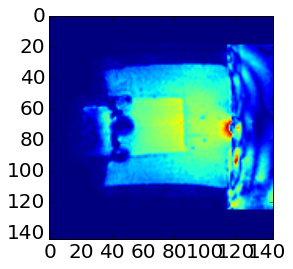

In [1011]:
plt.imshow(np.abs( complIm2[:,:,5,0]) )

In [ ]:
fig.add_subplot()

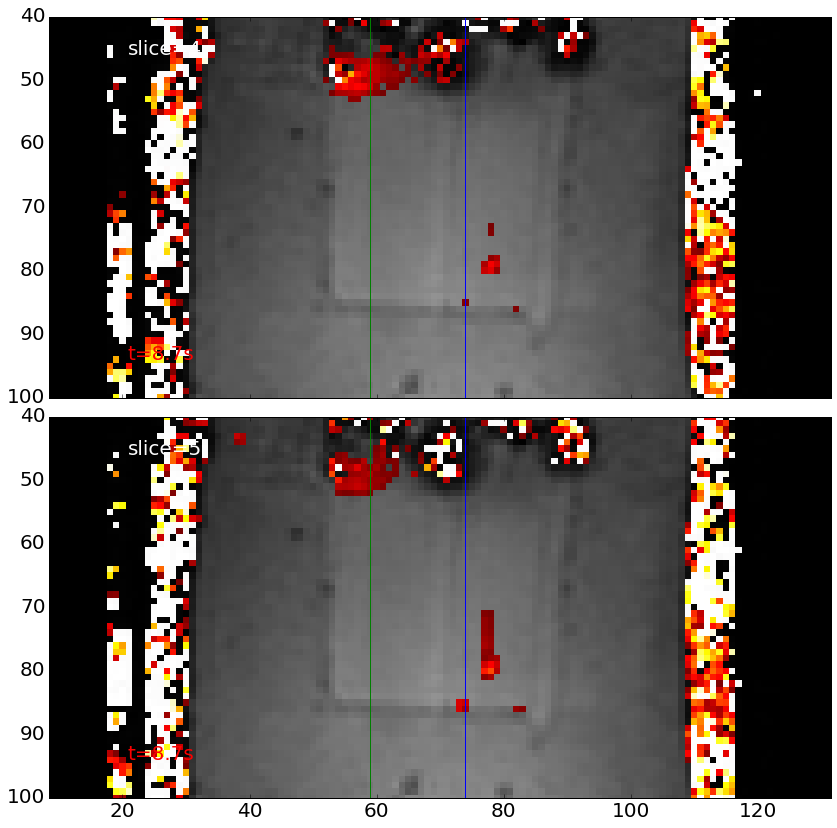

In [457]:
Si = 5
magDyn=2

magImg = np.abs(complIm1[:,:,Si,magDyn]).transpose()

Slices=[4,5]
dyns=[3]


fig,axTable=plt.subplots(nrows=len(Slices),ncols=len(dyns),subplot_kw=dict(xlim=[40,100],ylim=[100,40]),
                         sharey=True,sharex=True,squeeze=False,gridspec_kw=dict(wspace=0.05,hspace=0.05), 
                         figsize=(14,14))

for di in range(len(dyns)):
    dyn=dyns[di]
    for si in range(len(Slices)):
        slc = Slices[si] 
        ax=axTable[si,di]
        data1=tempdata1[:,:,slc,dyn].transpose() 
        data2=tempdata2[:,:,slc,dyn].transpose() 
        
        
        mask1 = data1 < 5.0
        mask2 = data2 < 5.0

        rgbaIm1 = image.cm.hot( rescaleIm(data1, vmin=0,vmax=30,trunc=True) )
        rgbaIm1[mask1,3]=0

        rgbaIm2 = image.cm.hot( rescaleIm(data2, vmin=0,vmax=30,trunc=True) )
        rgbaIm2[mask2,3]=0
        
        ax.imshow(magImg, cmap=image.cm.gray, interpolation='none')
        ax.imshow(rgbaIm1, interpolation='none')
        ax.imshow(rgbaIm2, interpolation='none')
        
        ax.plot( [74,74], ax.get_ylim() )
        ax.plot( [59,59], ax.get_ylim() )
        
        if di==0:
            plt.text(0.1,0.9,'slice=%d'%slc,color='white',transform=ax.transAxes)
        
        plt.text(0.1,0.1,'t=%0.1fs'%dyntimes1[dyn],color='red',transform=ax.transAxes)

In [127]:
#x10=np.arange(tempdata1.shape[0])
v1P=np.arange(tempdata1.shape[1])
v2P=np.arange(tempdata2.shape[1])

#x12=np.zeros_like(x10)

In [484]:
aff1=im1.get_affine()
aff2=im1.get_affine()
Mi1=78
Si=5

PR1, PA1, PS1, junk= aff1.dot( [ Mi1 + np.zeros_like(v1P), v1P, Si+np.zeros_like(v1P), np.ones_like(v1P) ] )

Mi2=59
PR2, PA2, PS2, junk= aff2.dot( [ Mi2 + np.zeros_like(v2P), v2P, Si+np.zeros_like(v2P), np.ones_like(v2P) ] )

#geom.rotate_mesh_volume(aff1[0:3,0:3], [78])

In [460]:
scaleBarEnds = np.linalg.inv(aff1 ).dot( [np.zeros(2), [0.0, 20.0] ,np.zeros(2), [1,1] ])

In [461]:
scaleBarEnds

array([[ 70.1956,  70.1956],
       [ 67.5505,  54.7053],
       [  1.6291,   1.6317],
       [  1.    ,   1.    ]])

In [370]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvecs = sonalleve.get_sonalleve_xdc_normals()
N = uxyz.shape[0]
uamp0 = np.ones(N) / N

simX=[0.0]
simY=[0.0]
simZ=np.linspace(0.03,0.2,num=400)

k0 = 2*pi*1.2e6/1540.0
P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, simX, simY, simZ,  
                                         subsampN=60, subsampDiam=0.0033, ROC=0.14)

P0offAX = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, [-0.006], simY, simZ,  
                                         subsampN=60, subsampDiam=0.0033, ROC=0.14)

In [394]:
simImX=np.linspace(-0.015, 0.015, 120)
simImY=np.linspace(-0.015, 0.015, 120)
simImZ=np.linspace(0.125, 0.155, 120)
P0im = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, simImX, simImY, [0.12],  
                                         subsampN=60, subsampDiam=0.0033, ROC=0.14)

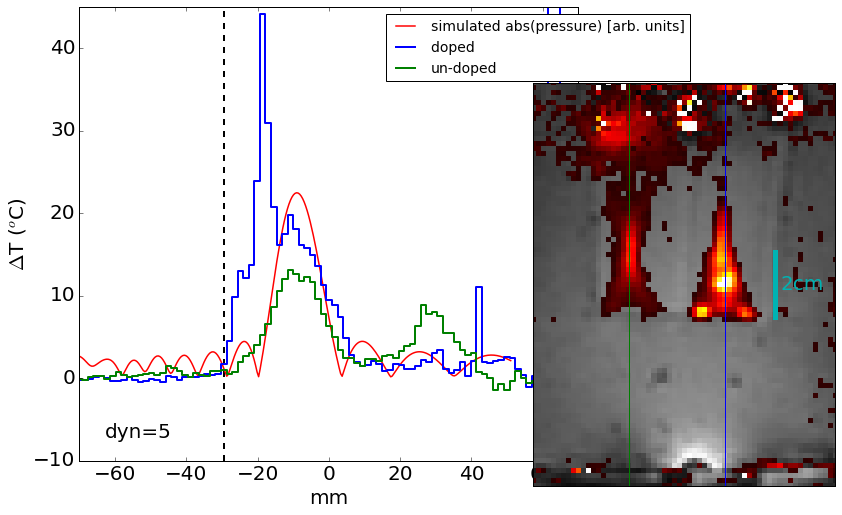

In [489]:
dyn=5
fig=plt.figure(figsize=(7,7))
ax1=fig.add_axes([0.0,0.1,0.99,0.9])

slice1 = tempdata1[:,:,5,dyn]
slice2 = tempdata2[:,:,5,dyn]

ax1.set_xlim([-70,70])
ax1.set_ylim([-10,45])
ax1.plot( (-29.5,-29.5), plt.gca().get_ylim(), 'k--',linewidth=2.0 )
#ax1.plot( (45,45), plt.gca().get_ylim(), 'k--',linewidth=2.0)

ax1.plot( (simZ*1000 -140 -9), 0.5*plt.gca().get_ylim()[1]*np.abs(P0.flat),'r',linewidth=1.5, label='simulated abs(pressure) [arb. units]')
#ax1.plot( (simZ*1000 -140 -9), 0.5*plt.gca().get_ylim()[1]*np.abs(P0offAX.flat),'r',linewidth=1.5, label='simulated abs(pressure) [arb. units]')


crv1=ax1.step( PA1, slice1[Mi1,:],'-',linewidth=2.0, label='doped ')
crv2=ax1.step( PA2, slice2[Mi2,:],'-',linewidth=2.0, label='un-doped')

#ax1.plot( PA1, 30*rescaleIm( np.abs(complIm1[78,:,5,1]) ), 'k' )


plt.xlabel('mm')
plt.ylabel(r'$\Delta$T ($^o$C)') 
plt.text(0.05,0.05,'dyn=%d'%dyn,color='black',transform=plt.gca().transAxes)
leg=ax1.legend(bbox_to_anchor=(0.6, 1), loc='upper left',fontsize=14.0)

ax2=fig.add_axes([0.8,0.05,0.8,0.8])

ax2.set_xlim([40,100])
ax2.set_ylim([120,40])
magImg = np.abs(complIm1[:,:,Si,1]).transpose()

rgbaIm1 = image.cm.hot( rescaleIm(slice1.transpose(), vmin=0,vmax=30,trunc=True) )
rgbaIm2 = image.cm.hot( rescaleIm(slice2.transpose(), vmin=0,vmax=30,trunc=True) )
mask1 = slice1.transpose() < 1.5
mask2 = slice2.transpose() < 1.5

rgbaIm1[mask1,3]=0
rgbaIm2[mask2,3]=0

ax2.imshow(magImg, cmap=image.cm.gray, interpolation='none')
ax2.imshow(rgbaIm2, interpolation='none')
ax2.imshow(rgbaIm1, interpolation='none')


ylim=ax2.get_ylim()
ax2.plot( [Mi1,Mi1], ylim, crv1[0].get_color() )
ax2.plot( [Mi2,Mi2], ylim, crv2[0].get_color() )
xlim=ax2.get_xlim()
barLocX=(xlim[0] + 0.8*(xlim[1]-xlim[0]) )*np.ones(2)
barLocY= scaleBarEnds[1,0:2] + ( sum(ylim)/2.0 - np.min(scaleBarEnds[1])  ) + (scaleBarEnds[1,1]-scaleBarEnds[1,0])/2.0
ax2.plot(barLocX, barLocY, color=(0.0,0.7,0.7), linewidth=5.0 )
ax2.text( barLocX[0]+1, sum(barLocY)/2.0, '2cm', color=(0.0,0.7,0.7), verticalalignment='center' )
ax2.tick_params(length=0, labelleft=False, labelbottom=False)


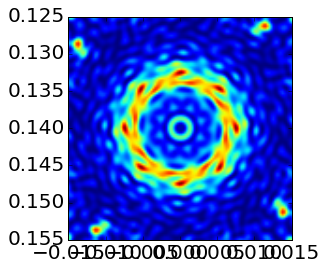

In [395]:
plt.imshow( np.abs(P0im[:,:,0].transpose())**2,extent=[simImY[0], simImY[-1], simImZ[-1], simImZ[0] ] )

In [ ]:
slice1 = tempdata1[:,:,5,dyn]

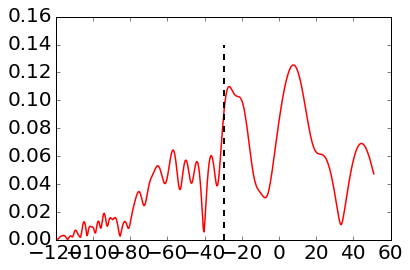

In [495]:
plt.plot( (simZ*1000 -140 -9), np.abs(P0offAX.flat)/np.max(np.abs(P0)),'r',linewidth=1.5)
plt.plot( (-29.5,-29.5), plt.gca().get_ylim(), 'k--',linewidth=2.0 )

In [449]:
(scaleBarEnds[1,1]-scaleBarEnds[1,0])/2.0

-6.4226071052189155

In [488]:
plt.plot( np.abs())

array([[[ 0.0024+0.0022j]]])

In [463]:
74.09/3.49, 82.43/4.19

(21.229226361031518, 19.673031026252982)

In [469]:
AA=5e-6
sqrt(80*1000*1540/AA)

4963869.458396343

In [498]:
AA*1e4*71.0/30.0

0.11833333333333335

In [ ]:
nibabel.parrec()

In [42]:
file1="/Users/Vandiver/Data/sonalleve/HifuMed_20160217/scan2_TemperatureMapping_20160217.PAR"
file2="/Users/Vandiver/Data/sonalleve/HifuMed_20160217/scan7_TemperatureMapping_20160217.PAR"

file1="/Users/Vandiver/Data/sonalleve/Hifu_20160314/scan41_TempCo_20160314.PAR"
file2="/Users/Vandiver/Data/sonalleve/Hifu_20160314/scan45_TempCo_20160314.PAR"

file1="/Users/Vandiver/Data/sonalleve/Hifu_20160317/scan22_TempCo_20160317.PAR"
file2="/Users/Vandiver/Data/sonalleve/Hifu_20160317/scan23_TempCo_20160317.PAR"


(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)
(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)

In [49]:
tempdata1.shape

(240, 240, 3, 30)

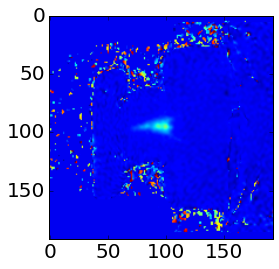

In [13]:
plt.imshow( tempdata2[:,:,5,8] )

In [43]:
idx0=np.arange(111,134)
idx1=np.arange(113,137)
idx2=np.arange(0,3)

#idx0=np.arange(80 ,110)
#idx1=np.arange(73, 120)
#idx0=np.arange(74 ,110)
#idx1=np.arange(67, 110)
#idx2=np.arange(3,9)

#idx2=[1]

#idx0=np.arange(0,35) + 150
#idx1=np.arange(0,35) + 160
#idx2=np.arange(0,3)

avgRoi=np.zeros(tempdata1.shape[0:3],dtype=bool)
avgRoi[np.ix_(idx0,idx1,idx2)]=True

avgTemp1 = np.mean( tempdata1[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )
avgTemp2 = np.mean( tempdata2[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )

maxTemp1 = np.max( tempdata1[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )
maxTemp2 = np.max( tempdata2[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )

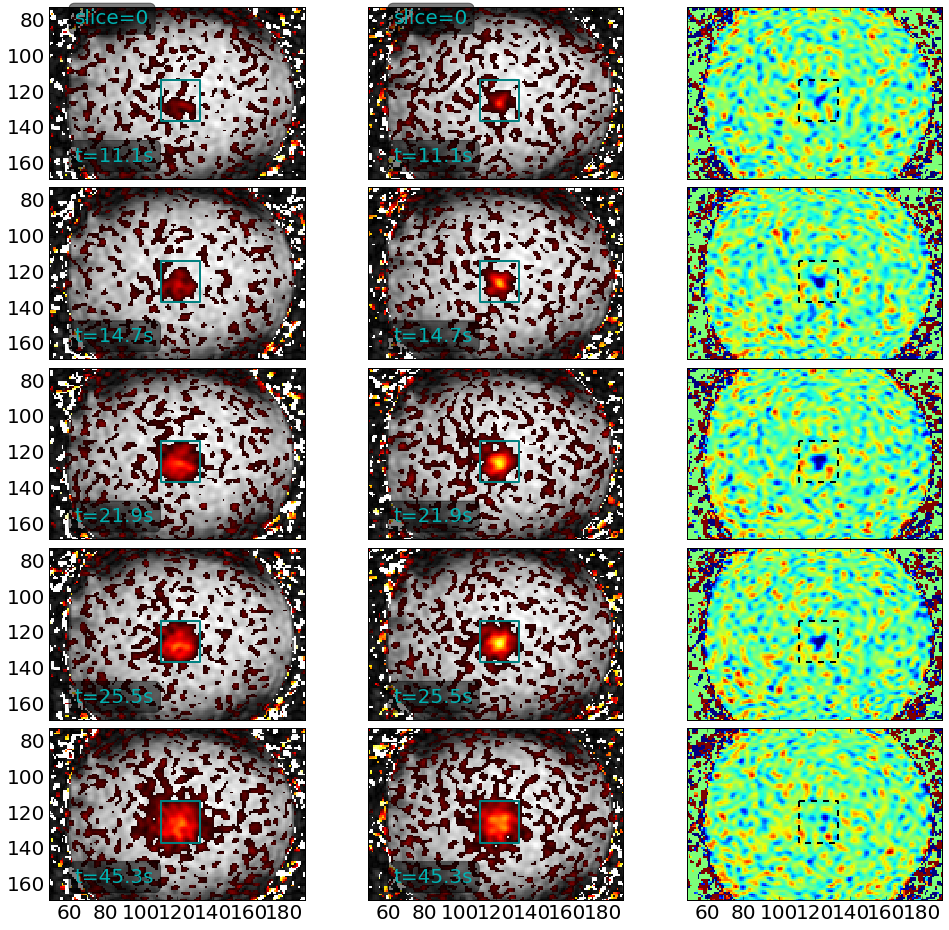

In [51]:
Si = 2
magDyn=2

magImg = rescaleIm( np.abs(complIm1[:,:,Si,magDyn]).transpose() )


dyns=[6,8,12,14,25]
#dyns=[3,6,8]
#dyns=[2,3,4,5,6,7,8]

#,subplot_kw=dict(xlim=[20,80],ylim=[80,20])


xlim=np.floor(tempdata1.shape[1]*np.array([1./2 - 1./5, 1./2 + 1./5]))
ylim=np.floor(tempdata1.shape[0]*np.array([1./2 + 1./5, 1./2 - 1./5]))
fig,axTable=plt.subplots(nrows=len(dyns),ncols=3,subplot_kw=dict(xlim=xlim,ylim=ylim),
                         sharey=True,sharex=True,squeeze=False,gridspec_kw=dict(wspace=0.25,hspace=0.05), 
                         figsize=(16,16))

sets = [(tempdata1,complIm1,im1, dyntimes1), (tempdata2,complIm2,im2, dyntimes2)]

props = dict(boxstyle='round', facecolor='black', alpha=0.5)

slc=0
for di in range(len(dyns)):
    dyn=dyns[di]
    for col in range(2):

        data = sets[col][0]
        
        ax=axTable[di,col]
        data1=data[:,:,slc,dyn].transpose() 
        mask1 =  data1 < 1.0 
        
        rgbaIm1 = image.cm.hot( rescaleIm(data1, vmin=0,vmax=30,trunc=True) )
        rgbaIm1[mask1,3]=0
        
        ax.imshow(magImg, cmap=image.cm.gray, vmin=0.0, vmax=0.95, interpolation='none')
        im=ax.imshow(rgbaIm1, interpolation='none')
        
        ax.plot( idx0[[0,0,-1,-1,0]], idx1[[0,-1,-1,0,0]], '-',linewidth=2.0, color=(0,.5,.5)  )
        
        if di==0:
            plt.text(0.1,0.9,'slice=%d'%slc, color=(0,.7,.7),transform=ax.transAxes,bbox=props)
        
        plt.text(0.1,0.1,'t=%0.1fs'%dyntimes1[dyn], color=(0,.7,.7),transform=ax.transAxes,bbox=props)
        
    #col 3
    ax=axTable[di,2]
    diff = (sets[0][0][:,:,slc,dyn] - sets[1][0][:,:,slc,dyn] ).transpose() 
    im=ax.imshow(diff, vmin=-10,vmax=10, interpolation='none')
    ax.plot( idx0[[0,0,-1,-1,0]], idx1[[0,-1,-1,0,0]], '--',linewidth=2.0, color=(0,0,0)  )

In [379]:
idx0starts=np.arange(70,85)
idx0end=112

idx1starts=np.arange(65,75)
idx1end=110

i2=np.arange(4,7)

sumDiffs=np.zeros([len(idx0starts),len(idx1starts)])
maxDiffs=np.zeros_like(sumDiffs)
i=0
j=0
for i0s in idx0starts:
    i0=np.arange(i0s,idx0end+1)
    j=0
    for i1s in idx1starts:
        i1=np.arange(i1s,idx1end+1)
        curve1=np.mean( tempdata1[np.ix_(i0,i1,i2)], axis=(0,1,2) )
        curve2=np.mean( tempdata2[np.ix_(i0,i1,i2)], axis=(0,1,2) )

        sumDiffs[i,j]=np.sum(curve1 - curve2)
        maxDiffs[i,j]=np.max(curve1 - curve2)
        j+=1
    i+=1

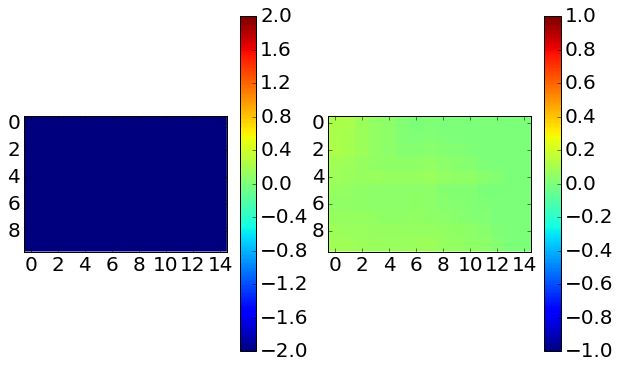

In [380]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow( sumDiffs.transpose(), interpolation='none',vmin=-2,vmax=2)
plt.colorbar()
plt.subplot(122)
plt.imshow( maxDiffs.transpose(), interpolation='none',vmin=-1,vmax=1)
plt.colorbar()

In [366]:
idx0starts[4],idx1starts[2]

(74, 67)

In [ ]:
idx0=np.arange(75,110)
idx1=np.arange(85,105)
idx2=np.arange(3,8)

avgTemp1 = np.mean( tempdata1[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )
avgTemp2 = np.mean( tempdata2[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )


In [145]:
idx0=np.arange(70,95)
idx1=np.arange(70,95)
idx2=np.arange(4,12)

avgTemp1 = np.mean( tempdata1[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )
avgTemp2 = np.mean( tempdata2[np.ix_(idx0,idx1,idx2)], axis=(0,1,2) )

In [240]:
np.sum(avgTemp2-avgTemp1)

-15.697479913055858

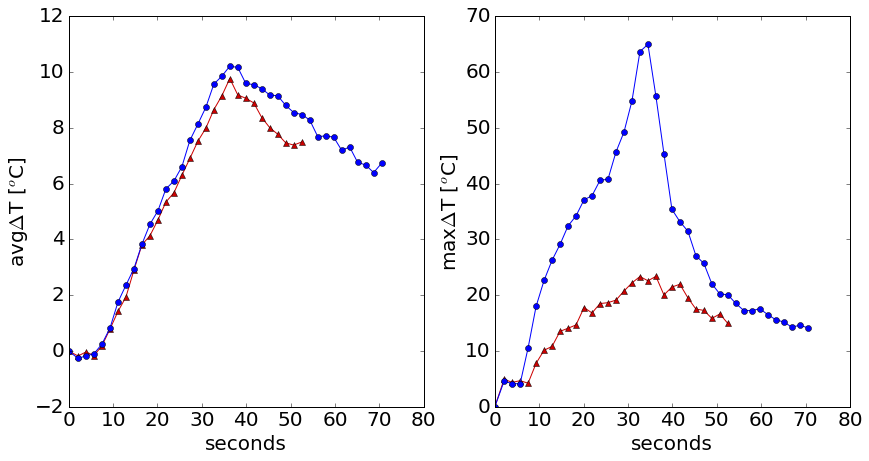

In [45]:
fig=plt.figure(figsize=(14,7))
ax=fig.add_subplot(121)
ax.plot( dyntimes1,avgTemp1,'-^',color=(.8,0,0))
ax.plot( dyntimes2,avgTemp2,'b-o')
ax.set_xlabel('seconds')
ax.set_ylabel(r'avg$\Delta$T [$^o$C]')

ax=fig.add_subplot(122)
ax.plot( dyntimes1,maxTemp1,'-^',color=(.8,0,0))
ax.plot( dyntimes2,maxTemp2,'b-o')
ax.set_xlabel('seconds')
ax.set_ylabel(r'max$\Delta$T [$^o$C]')

In [47]:
avgTemp1Stack = np.mean( tempdata1[np.ix_(idx0,idx1)], axis=(0,1) )
avgTemp2Stack = np.mean( tempdata2[np.ix_(idx0,idx1)], axis=(0,1) )

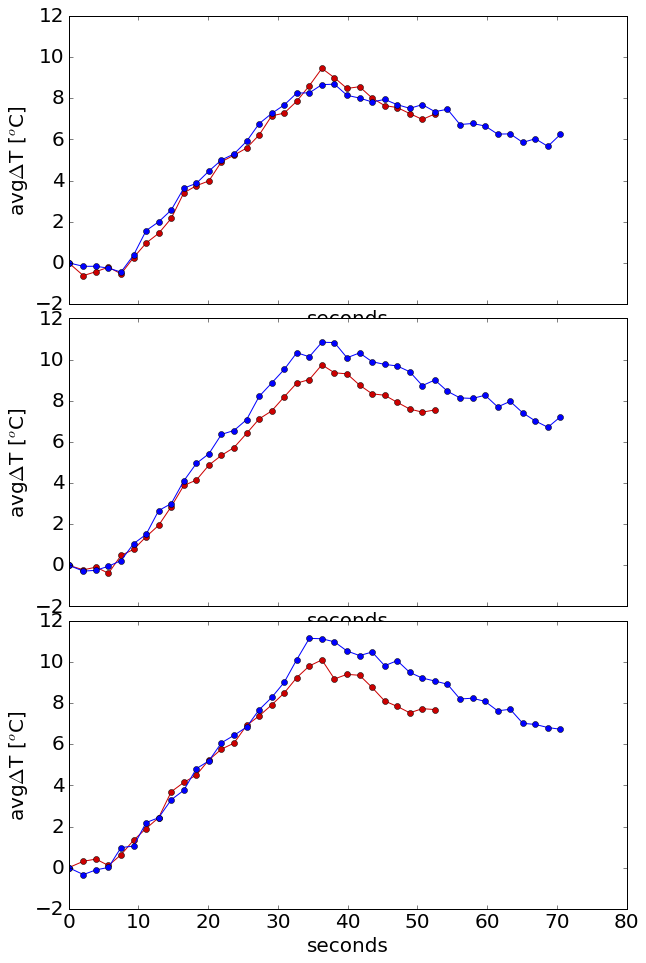

In [48]:
npl=min([len(avgTemp1Stack),len(avgTemp2Stack)])
slcs=[0,1,2]
npl=len(slcs)
fig,axTable=plt.subplots(nrows=npl,ncols=1,
                         sharey=True,sharex=True,squeeze=False,gridspec_kw=dict(wspace=0.25,hspace=0.05), figsize=(10,16))

for i in range(axTable.shape[0]):
    si=slcs[i]
    ax=axTable[i,0]
    ax.plot( dyntimes1,avgTemp1Stack[si],'-o',color=(.8,0,0))
    ax.plot( dyntimes2,avgTemp2Stack[si],'b-o')

    ax.set_xlabel('seconds')
    ax.set_ylabel(r'avg$\Delta$T [$^o$C]')     